# ColabでJulia言語を使った統計学の勉強の仕方

* 黒木玄
* 2025-05-13, 2025-06-03
$
\newcommand\op{\operatorname}
\newcommand\R{{\mathbb R}}
\newcommand\Z{{\mathbb Z}}
\newcommand\var{\op{var}}
\newcommand\std{\op{std}}
\newcommand\eps{\varepsilon}
\newcommand\T[1]{T_{(#1)}}
\newcommand\bk{\bar\kappa}
\newcommand\X{{\mathscr X}}
$

このノートブックは[Google Colabで実行できる](https://colab.research.google.com/github/genkuroki/Statistics/blob/master/2022/07-3%20How%20to%20use%20Julia%20language%20in%20Google%20Colab%20for%20learning%20statistics.ipynb).

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Google-ColabでのJulia言語の使い方" data-toc-modified-id="Google-ColabでのJulia言語の使い方-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Google ColabでのJulia言語の使い方</a></span><ul class="toc-item"><li><span><a href="#ColabでのJuliaの実行" data-toc-modified-id="ColabでのJuliaの実行-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>ColabでのJuliaの実行</a></span></li><li><span><a href="#グラフの描き方" data-toc-modified-id="グラフの描き方-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>グラフの描き方</a></span></li><li><span><a href="#標準正規分布乱数のプロット" data-toc-modified-id="標準正規分布乱数のプロット-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>標準正規分布乱数のプロット</a></span></li><li><span><a href="#確率分布の扱い方" data-toc-modified-id="確率分布の扱い方-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>確率分布の扱い方</a></span></li><li><span><a href="#正規分布の確率密度函数のプロット" data-toc-modified-id="正規分布の確率密度函数のプロット-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>正規分布の確率密度函数のプロット</a></span></li></ul></li><li><span><a href="#Anscombeの例のプロット" data-toc-modified-id="Anscombeの例のプロット-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anscombeの例のプロット</a></span><ul class="toc-item"><li><span><a href="#RDatasets.jlパッケージのインストール" data-toc-modified-id="RDatasets.jlパッケージのインストール-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RDatasets.jlパッケージのインストール</a></span></li><li><span><a href="#データのプロットの仕方" data-toc-modified-id="データのプロットの仕方-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>データのプロットの仕方</a></span></li></ul></li><li><span><a href="#Datasaurusの散布図のプロット" data-toc-modified-id="Datasaurusの散布図のプロット-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Datasaurusの散布図のプロット</a></span><ul class="toc-item"><li><span><a href="#データの取得" data-toc-modified-id="データの取得-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>データの取得</a></span></li><li><span><a href="#散布図の作成" data-toc-modified-id="散布図の作成-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>散布図の作成</a></span></li></ul></li><li><span><a href="#中心極限定理のプロット" data-toc-modified-id="中心極限定理のプロット-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>中心極限定理のプロット</a></span><ul class="toc-item"><li><span><a href="#素朴なワークフロー" data-toc-modified-id="素朴なワークフロー-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>素朴なワークフロー</a></span></li><li><span><a href="#Revise.jlを使うワークフロー" data-toc-modified-id="Revise.jlを使うワークフロー-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Revise.jlを使うワークフロー</a></span></li><li><span><a href="#問題:-自分で関数を定義して実行してみよ." data-toc-modified-id="問題:-自分で関数を定義して実行してみよ.-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>問題: 自分で関数を定義して実行してみよ.</a></span></li></ul></li></ul></div>

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

haskey(ENV, "COLAB_GPU") && (ENV["JULIA_PKG_PRECOMPILE_AUTO"] = "0")
import Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd begin
using Distributions
using RDatasets
using StatsPlots
default(fmt=:png, size=(400, 250), titlefontsize=12)
end

## Google ColabでのJulia言語の使い方

### ColabでのJuliaの実行

(1) ブラウザでGoogleアカウントのどれかにログインしておきます.

(2) [Google Colab](https://colab.research.google.com/)にアクセスする.

(3) 「ノートブックを開く」の「GitHub」を選択する.

(4) GitHubにおいてある `ipynb` ファイルのURLを入力してEnterキーを押す.  例えば

 * `https://github.com/genkuroki/Statistics/blob/master/2022/07-3%20How%20to%20use%20Julia%20language%20in%20Google%20Colab%20for%20learning%20statistics.ipynb`

というURLを入力する.

(5) 実際にその例のURLを入力してEnterキーを押すと, このファイルがGoogle Colabで開かれる.

(6) そのノートブックの全体をColabで実行し直したければ, 「ランタイム」→「すべてのセルを実行」を選択する.

(7) 適当にGoogle Colabの使い方を検索して調べればより詳しい使い方が分かる.


* 各セルの先頭に `?` と入力した後に関数名などを入れるとヘルプを読むことができる.
* 各セルの先頭に `]` と入力した後にパッケージ管理モードのコマンドを入力して実行できる.
* タブキーによる補完を使える.
* 各セルの最後に `;` を付けて実行すると計算結果が表示されない.

__問題:__ 以上を実際に行ってみよ.

In [2]:
1 + 1

2

In [3]:
sin(pi/6)

0.49999999999999994

In [4]:
sinpi(1/6)

0.5

### グラフの描き方

(7) Colabで統計学対応のグラフ作画パッケージを使うためには次を実行する:

```julia
import Pkg
Pkg.add("StatsPlots")
using StatsPlots
```

このノートブックでは最初のセルでこれと同等のことを実行できるようにしてあるので, 最初のセルを実行しておけばよい.

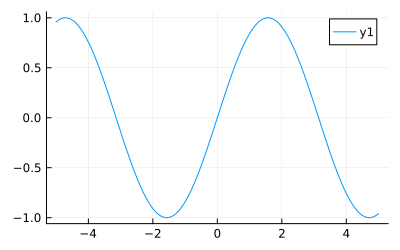

In [5]:
plot(sin)

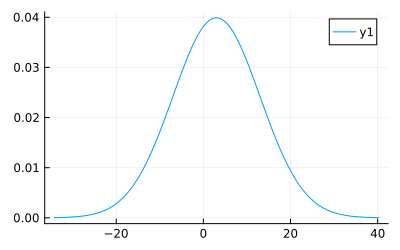

In [6]:
plot(Normal(3, 10))

### 標準正規分布乱数のプロット

In [7]:
# 標準正規分布の乱数を10^4個生成
Z = randn(10^4);

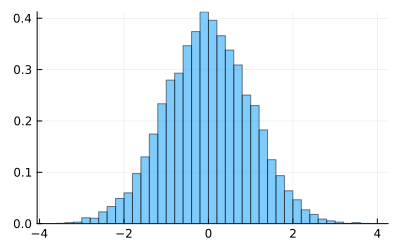

In [8]:
histogram(Z; norm=true, alpha=0.5, label="")

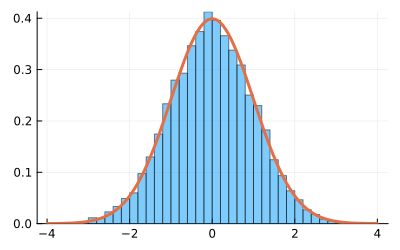

In [9]:
plot!(x -> exp(-x^2/2)/sqrt(2pi), -4, 4; label="", lw=3)

### 確率分布の扱い方

(7) 確率分布を扱うためのパッケージを使うためには次を実行する:

```julia
import Pkg
Pkg.add("Distributions")
using Distributions
```

このノートブックでは最初のセルでこれと同等のことを実行できるようにしてあるので, 最初のセルを実行しておけばよい.

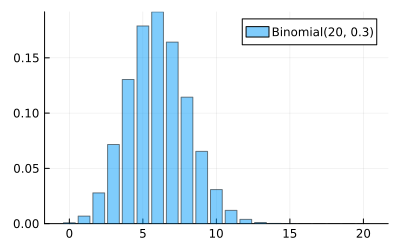

In [10]:
dist = Binomial(20, 0.3)
bar(dist; alpha=0.5, label="Binomial(20, 0.3)")

### 正規分布の確率密度函数のプロット

In [11]:
X = rand(Normal(2, 3), 10^4);

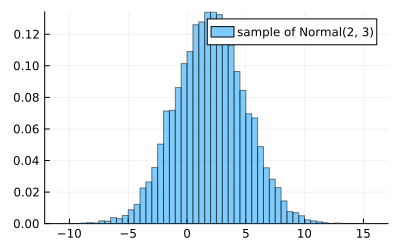

In [12]:
histogram(X; norm=true, alpha=0.5, label="sample of Normal(2, 3)")

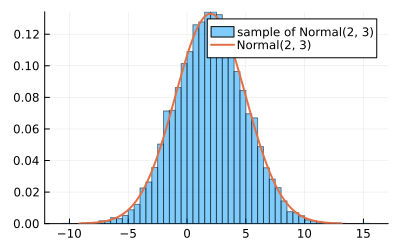

In [13]:
plot!(Normal(2, 3); label="Normal(2, 3)", lw=2)

## Anscombeの例のプロット

### RDatasets.jlパッケージのインストール

確率分布を扱うためのパッケージを入れるためには次を実行する:

```julia
import Pkg
Pkg.add("RDatasets")
using RDatasets
```

このノートブックでは最初のセルでこれと同等のことを実行できるようにしてあるので, 最初のセルを実行しておけばよい.

In [14]:
anscombe = dataset("datasets", "anscombe")

Row,X1,X2,X3,X4,Y1,Y2,Y3,Y4
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,10,10,10,8,8.04,9.14,7.46,6.58
2,8,8,8,8,6.95,8.14,6.77,5.76
3,13,13,13,8,7.58,8.74,12.74,7.71
4,9,9,9,8,8.81,8.77,7.11,8.84
5,11,11,11,8,8.33,9.26,7.81,8.47
6,14,14,14,8,9.96,8.1,8.84,7.04
7,6,6,6,8,7.24,6.13,6.08,5.25
8,4,4,4,19,4.26,3.1,5.39,12.5
9,12,12,12,8,10.84,9.13,8.15,5.56


### データのプロットの仕方

以下ではデータ1の場合のプロットの仕方を説明しよう.

In [15]:
# x, y にデータを入れる
x, y = anscombe.X1, anscombe.Y1

([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5], [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])

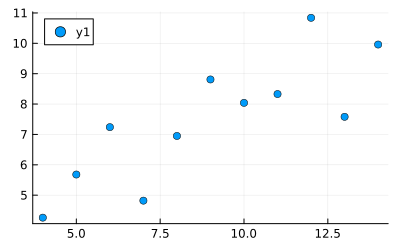

In [16]:
# 散布図を描いてみる
using StatsPlots
scatter(x, y)

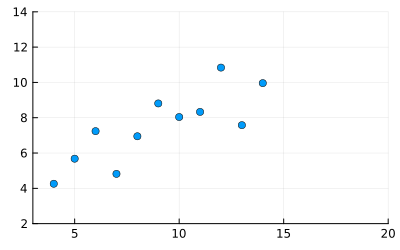

In [17]:
# xlim, ylimなどを追加
scatter(x, y; label="", xlim=(3, 20), ylim=(2, 14))

In [18]:
# データの標本平均や不偏分散・不偏共分散を計算
xbar = mean(x)

9.0

In [19]:
ybar = mean(y)

7.500909090909093

In [20]:
sx2 = var(x)

11.0

In [21]:
sy2 = var(y)

4.127269090909091

In [22]:
sxy = cov(x, y)

5.501

In [23]:
betahat = sxy/sx2

0.5000909090909091

In [24]:
alphahat = ybar - betahat*xbar

3.0000909090909103

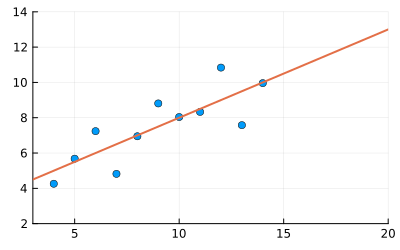

In [25]:
scatter(x, y; label="", xlim=(3, 20), ylim=(2, 14))
plot!(x -> alphahat + betahat*x, 3, 20; label="", lw=2)

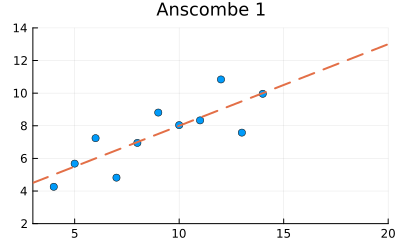

In [26]:
scatter(x, y; label="", xlim=(3, 20), ylim=(2, 14), title="Anscombe 1")
plot!(x -> alphahat + betahat*x, 3, 20; label="", lw=2, ls=:dash)

In [27]:
# design matrix
X = x .^ (0:1)'

11×2 Matrix{Int64}:
 1  10
 1   8
 1  13
 1   9
 1  11
 1  14
 1   6
 1   4
 1  12
 1   7
 1   5

In [28]:
# 最小二乗法を一発実現 (計画行列の一般逆行列をyにかける)
alphahat2, betahat2 = X \ y

2-element Vector{Float64}:
 3.000090909090909
 0.500090909090909

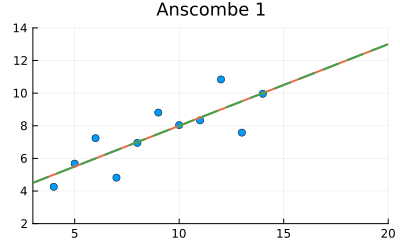

In [29]:
# 2つの直線はぴったり重なり合う.
scatter(x, y; label="", xlim=(3, 20), ylim=(2, 14), title="Anscombe 1")
plot!(x -> alphahat + betahat*x, 3, 20; label="", lw=2)
plot!(x -> alphahat2 + betahat2*x, 3, 20; label="", lw=2, ls=:dash)

__問題:__ 他のアンスコムのデータについて同様のグラフを作成せよ.

## Datasaurusの散布図のプロット

以下のデータは「[条件付き確率分布, 尤度, 推定, 記述統計](https://nbviewer.org/github/genkuroki/Statistics/blob/master/2022/06%20Conditional%20distribution%2C%20likelihood%2C%20estimation%2C%20and%20summary.ipynb)」からのコピー＆ペースト.

### データの取得

<!--
* http://www.thefunctionalart.com/2016/08/download-datasaurus-never-trust-summary.html
  * https://www.dropbox.com/sh/xaxpz3pm5r5awes/AADUbGVagF9i4RmM9JkPtviEa?dl=0
-->
* https://www.dropbox.com/sh/xaxpz3pm5r5awes/AADUbGVagF9i4RmM9JkPtviEa?dl=0
* https://visualizing.jp/the-datasaurus-dozen/
* https://www.openintro.org/data/index.php?data=datasaurus

In [30]:
datasaurus = [
    55.3846 97.1795
    51.5385 96.0256
    46.1538 94.4872
    42.8205 91.4103
    40.7692 88.3333
    38.7179 84.8718
    35.6410 79.8718
    33.0769 77.5641
    28.9744 74.4872
    26.1538 71.4103
    23.0769 66.4103
    22.3077 61.7949
    22.3077 57.1795
    23.3333 52.9487
    25.8974 51.0256
    29.4872 51.0256
    32.8205 51.0256
    35.3846 51.4103
    40.2564 51.4103
    44.1026 52.9487
    46.6667 54.1026
    50.0000 55.2564
    53.0769 55.6410
    56.6667 56.0256
    59.2308 57.9487
    61.2821 62.1795
    61.5385 66.4103
    61.7949 69.1026
    57.4359 55.2564
    54.8718 49.8718
    52.5641 46.0256
    48.2051 38.3333
    49.4872 42.1795
    51.0256 44.1026
    45.3846 36.4103
    42.8205 32.5641
    38.7179 31.4103
    35.1282 30.2564
    32.5641 32.1795
    30.0000 36.7949
    33.5897 41.4103
    36.6667 45.6410
    38.2051 49.1026
    29.7436 36.0256
    29.7436 32.1795
    30.0000 29.1026
    32.0513 26.7949
    35.8974 25.2564
    41.0256 25.2564
    44.1026 25.6410
    47.1795 28.7180
    49.4872 31.4103
    51.5385 34.8718
    53.5897 37.5641
    55.1282 40.6410
    56.6667 42.1795
    59.2308 44.4872
    62.3077 46.0256
    64.8718 46.7949
    67.9487 47.9487
    70.5128 53.7180
    71.5385 60.6410
    71.5385 64.4872
    69.4872 69.4872
    46.9231 79.8718
    48.2051 84.1026
    50.0000 85.2564
    53.0769 85.2564
    55.3846 86.0256
    56.6667 86.0256
    56.1538 82.9487
    53.8462 80.6410
    51.2821 78.7180
    50.0000 78.7180
    47.9487 77.5641
    29.7436 59.8718
    29.7436 62.1795
    31.2821 62.5641
    57.9487 99.4872
    61.7949 99.1026
    64.8718 97.5641
    68.4615 94.1026
    70.7692 91.0256
    72.0513 86.4103
    73.8462 83.3333
    75.1282 79.1026
    76.6667 75.2564
    77.6923 71.4103
    79.7436 66.7949
    81.7949 60.2564
    83.3333 55.2564
    85.1282 51.4103
    86.4103 47.5641
    87.9487 46.0256
    89.4872 42.5641
    93.3333 39.8718
    95.3846 36.7949
    98.2051 33.7180
    56.6667 40.6410
    59.2308 38.3333
    60.7692 33.7180
    63.0769 29.1026
    64.1026 25.2564
    64.3590 24.1026
    74.3590 22.9487
    71.2821 22.9487
    67.9487 22.1795
    65.8974 20.2564
    63.0769 19.1026
    61.2821 19.1026
    58.7179 18.3333
    55.1282 18.3333
    52.3077 18.3333
    49.7436 17.5641
    47.4359 16.0256
    44.8718 13.7180
    48.7179 14.8718
    51.2821 14.8718
    54.1026 14.8718
    56.1538 14.1026
    52.0513 12.5641
    48.7179 11.0256
    47.1795  9.8718
    46.1538  6.0256
    50.5128  9.4872
    53.8462 10.2564
    57.4359 10.2564
    60.0000 10.6410
    64.1026 10.6410
    66.9231 10.6410
    71.2821 10.6410
    74.3590 10.6410
    78.2051 10.6410
    67.9487  8.7180
    68.4615  5.2564
    68.2051  2.9487
    37.6923 25.7692
    39.4872 25.3846
    91.2821 41.5385
    50.0000 95.7692
    47.9487 95.0000
    44.1026 92.6923
];

### 散布図の作成

In [31]:
# 行列Aの第j列はA[:,j]
@show datasaurus[:,1];

datasaurus[:, 1] = [55.3846, 51.5385, 46.1538, 42.8205, 40.7692, 38.7179, 35.641, 33.0769, 28.9744, 26.1538, 23.0769, 22.3077, 22.3077, 23.3333, 25.8974, 29.4872, 32.8205, 35.3846, 40.2564, 44.1026, 46.6667, 50.0, 53.0769, 56.6667, 59.2308, 61.2821, 61.5385, 61.7949, 57.4359, 54.8718, 52.5641, 48.2051, 49.4872, 51.0256, 45.3846, 42.8205, 38.7179, 35.1282, 32.5641, 30.0, 33.5897, 36.6667, 38.2051, 29.7436, 29.7436, 30.0, 32.0513, 35.8974, 41.0256, 44.1026, 47.1795, 49.4872, 51.5385, 53.5897, 55.1282, 56.6667, 59.2308, 62.3077, 64.8718, 67.9487, 70.5128, 71.5385, 71.5385, 69.4872, 46.9231, 48.2051, 50.0, 53.0769, 55.3846, 56.6667, 56.1538, 53.8462, 51.2821, 50.0, 47.9487, 29.7436, 29.7436, 31.2821, 57.9487, 61.7949, 64.8718, 68.4615, 70.7692, 72.0513, 73.8462, 75.1282, 76.6667, 77.6923, 79.7436, 81.7949, 83.3333, 85.1282, 86.4103, 87.9487, 89.4872, 93.3333, 95.3846, 98.2051, 56.6667, 59.2308, 60.7692, 63.0769, 64.1026, 64.359, 74.359, 71.2821, 67.9487, 65.8974, 63.0769, 61.2821, 58.7179,

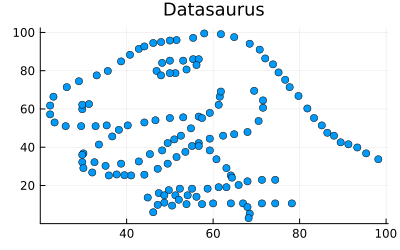

In [32]:
scatter(datasaurus[:,1], datasaurus[:,2]; label="", title="Datasaurus")

__問題:__ [Datasaurusについて検索](https://www.google.com/search?q=Datasaurus)して見つけた解説を読め.

## 中心極限定理のプロット

### 素朴なワークフロー

以下のセルの内容を julia の `julia> ` プロンプトに順番に入力すれば(コピー＆ペーストすれば)同じ結果が得られる.  各行の最後にセミコロン `;` を追加すれば計算結果の出力を抑制できる.

In [33]:
# 確率分布を dist と書く.
dist = Gamma(2, 3)

Gamma{Float64}(α=2.0, θ=3.0)

In [34]:
# 確率分布 dist のサイズ n のサンプルを L 個生成
n = 10
L = 10^4
Xs = [rand(dist, n) for _ in 1:L]

10000-element Vector{Vector{Float64}}:
 [1.0334943914540535, 2.2017752750123005, 2.6220508549350146, 1.8500739133833057, 6.799108088999941, 16.278649254127792, 2.408943566576445, 19.174011552580254, 7.906697375581828, 3.4691557256277883]
 [9.570935222601097, 4.841896859589427, 6.172182769852553, 7.063959778161561, 3.251047644273177, 2.8855779559013555, 8.07741068375114, 16.705959956127888, 7.886049472489073, 0.6370815425151354]
 [1.57059770250498, 13.86331876373294, 2.2151744556610407, 4.0776535319303955, 10.60681908699032, 5.600713166294353, 12.03681343940733, 10.4903418082311, 5.25512748284028, 6.272995507313661]
 [4.442019168315729, 13.519988689456241, 4.656281075628113, 0.0859860195842228, 6.514675806528146, 3.8817025812683985, 3.472174703114275, 2.7650632990005857, 9.347123495526523, 4.1375511519498]
 [2.235296499151902, 0.22841112015801343, 9.081914915537004, 8.57069424994634, 4.601803416231542, 6.016583794757806, 9.563068432974902, 1.0707001467330723, 6.677728087511269, 5.911213

In [35]:
# L個のサイズnのサンプルの各々の標本平均を計算
Xbars = mean.(Xs)

10000-element Vector{Float64}:
 6.374395999827872
 6.7092101885262405
 7.19895549449064
 5.282256599037203
 5.395741408435635
 6.2210579234202
 5.533856487486338
 8.001724889950513
 5.951541878009038
 6.640579331077521
 5.842517568445041
 6.1441113823800375
 6.882106107347473
 ⋮
 4.751195928968703
 7.707386199754221
 4.131927250872849
 7.513625924680582
 6.032636747035932
 3.727201518429342
 7.374902733188018
 4.707675275057994
 7.372869875999966
 8.100589347709175
 5.490913584990046
 5.358513119434711

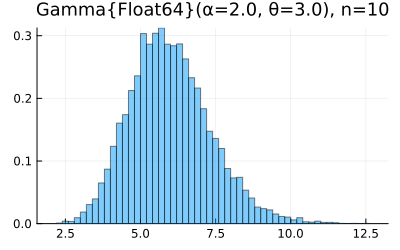

In [36]:
# Xbarのヒストグラムを表示
histogram(Xbars; norm=true, alpha=0.5, label="", title="$dist, n=$n")

In [37]:
# 中心極限定理による正規分布近似を設定
mu = mean(dist)
sigma = std(dist)
normal_approx = Normal(mu, sigma/sqrt(n))

Normal{Float64}(μ=6.0, σ=1.3416407864998736)

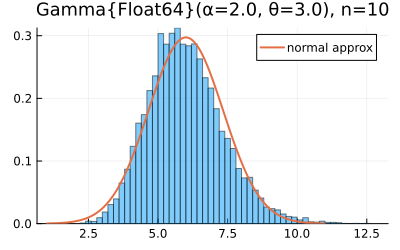

In [38]:
# 上のグラフに重ねて正規分布をプロット
plot!(normal_approx; label="normal approx", lw=2)

$n=10$ が小さすぎてずれが大きい.

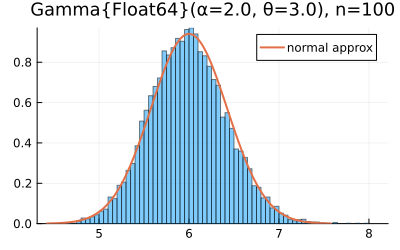

In [39]:
# nを大きくしてやり直してみる.
n = 100
L = 10^4
Xs = [rand(dist, n) for _ in 1:L]
Xbars = mean.(Xs)
histogram(Xbars; norm=true, alpha=0.5, label="", title="$dist, n=$n")
mu = mean(dist)
sigma = std(dist)
normal_approx = Normal(mu, sigma/sqrt(n))
plot!(normal_approx; label="normal approx", lw=2)

$n=100$ にしたら, 正規分布とよく一致するようになった.

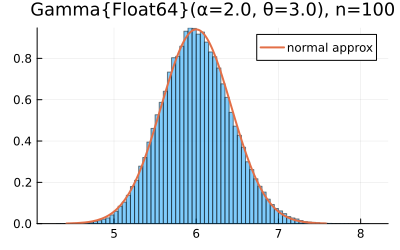

In [40]:
# Lも大きくしてやり直してみる.
n = 100
L = 10^5
Xs = [rand(dist, n) for _ in 1:L]
Xbars = mean.(Xs)
histogram(Xbars; norm=true, alpha=0.5, label="", title="$dist, n=$n")
mu = mean(dist)
sigma = std(dist)
normal_approx = Normal(mu, sigma/sqrt(n))
plot!(normal_approx; label="normal approx", lw=2)

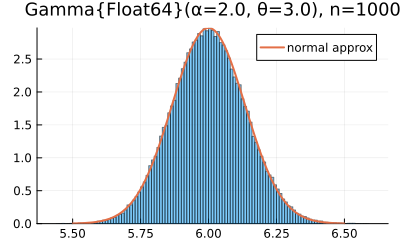

In [41]:
# Lも大きくしてやり直してみる.
n = 1000
L = 10^5
Xs = [rand(dist, n) for _ in 1:L]
Xbars = mean.(Xs)
histogram(Xbars; norm=true, alpha=0.5, label="", title="$dist, n=$n")
mu = mean(dist)
sigma = std(dist)
normal_approx = Normal(mu, sigma/sqrt(n))
plot!(normal_approx; label="normal approx", lw=2)

### Revise.jlを使うワークフロー

上のように素朴に毎回コードを入力することは非常に面倒である.

似た仕事は函数化して1行の入力で実行できるようにしておく方がよい.

しかし, 函数の定義を `julia> ` プロンプトに直接入力すると, 試行錯誤で函数の定義を何度も変える作業が非常に面倒になる. 

もしも, 函数の定義をファイルに書いておき, ファイル内の函数の定義を書き換えると, 自動的に `julia> ` プロンプトの側に函数の定義の変更が反映されるようにできれば非常に便利である. それを実現するのが [Revise.jl](https://github.com/timholy/Revise.jl) パッケージである. Revise.jlパッケージは

```
pkg> add Revise
```

でインストールできる.

### 問題: 自分で関数を定義して実行してみよ.

以下のセルのように関数を定義しておくと, 同じような仕事を何度も楽に実行できるようになる.

In [42]:
using StatsPlots
using Distributions
default(size=(400, 250), titlefontsize=10)

function hello_sine()
    println("Hello, Sine!")
    plot(sin; label="y=sin(x)")
end

function plot_central_limit_theorem(dist, n; L=10^4, bin=:auto)
    distname = mydistname(dist)
    mu = mean(dist)
    sigma = std(dist)
    Xs = [rand(dist, n) for _ in 1:L]
    Xbars = mean.(Xs)
    normal_approx = Normal(mu, sigma/sqrt(n))
    
    if dist isa DiscreteUnivariateDistribution
        mu = mean(dist)
        sigma = std(dist)
        a = round(n*mu - 4.5sqrt(n)*sigma)
        b = round(n*mu + 4.5sqrt(n)*sigma)
        ran = a-0.5:b+0.5
        bin = ran / n
    end
    
    histogram(Xbars; bin, norm=true, alpha=0.5, label="Xbars")
    plot!(normal_approx; lw=2, label="normal approx")
    title!("$distname, n=$n")
end

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))
mydistname(dist) = replace(string(dist), r"{[^}]*}"=>"")

function plot_dist(dist; xlim0=nothing)
    distname = mydistname(dist)
    if isnothing(xlim0)
        mu = mean(dist)
        sigma = std(dist)
        a = max(minimum(dist), mu - 4.5sigma)
        b = min(maximum(dist), mu + 4.5sigma)
        if dist isa DiscreteUnivariateDistribution
            a, b = a-1, b+1
        else
            a, b = a-0.025(b-a), b+0.025(b-a)
        end
        xlim0 = (a, b)
    end
    plot(x -> mypdf(dist, x), xlim0...; label="", title="$distname")
end

function plot_dist_clt(dist, n; L=10^4, xlim0=nothing)
    P0 = plot_dist(dist; xlim0)
    P1 = plot_central_limit_theorem(dist, n; L)
    plot(P0, P1; size=(800, 250), layout=(1, 2))
end

plot_dist_clt (generic function with 1 method)

Hello, Sine!


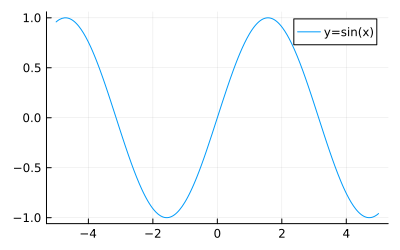

In [43]:
hello_sine()

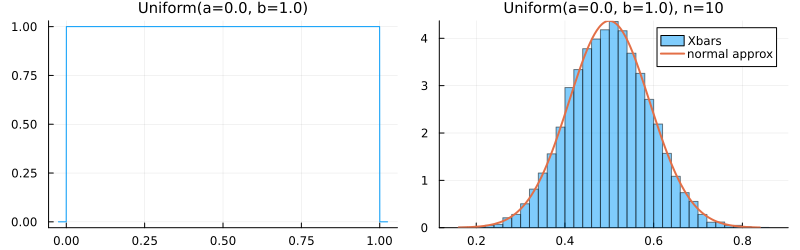

In [44]:
plot_dist_clt(Uniform(), 10)

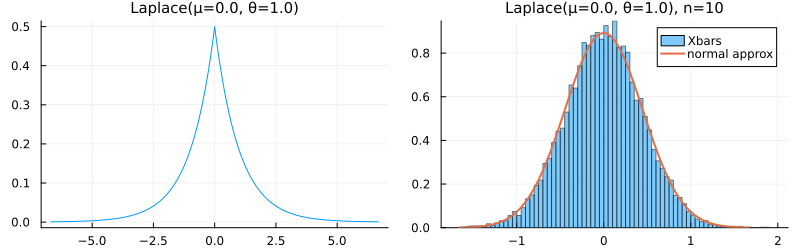

In [45]:
plot_dist_clt(Laplace(), 10)

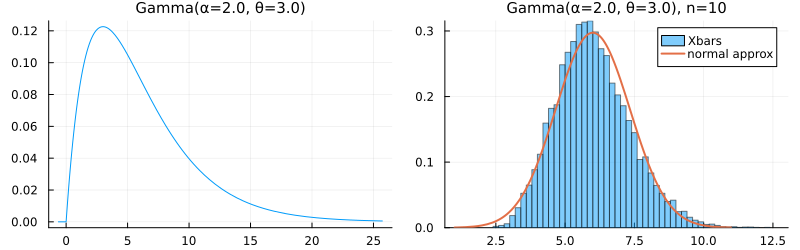

In [46]:
plot_dist_clt(Gamma(2, 3), 10)

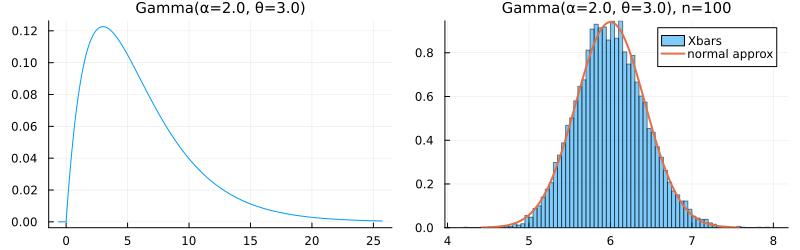

In [47]:
plot_dist_clt(Gamma(2, 3), 100)

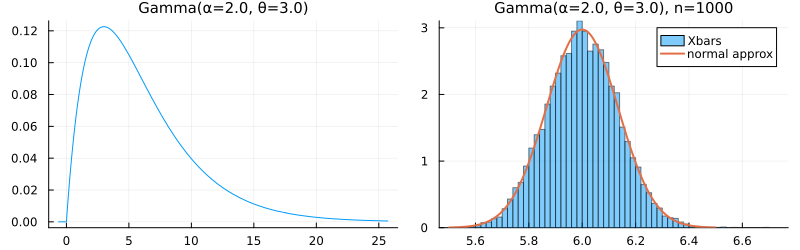

In [48]:
plot_dist_clt(Gamma(2, 3), 1000)

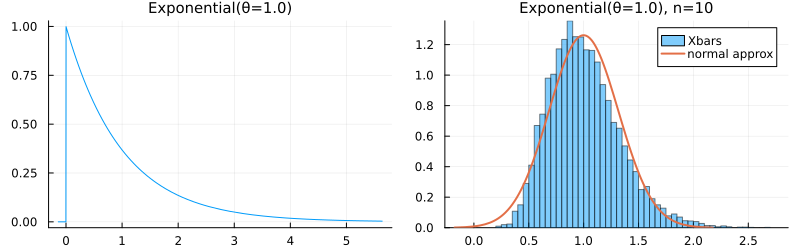

In [49]:
plot_dist_clt(Exponential(), 10)

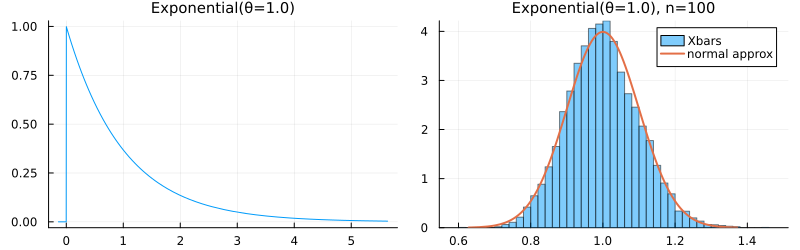

In [50]:
plot_dist_clt(Exponential(), 100)

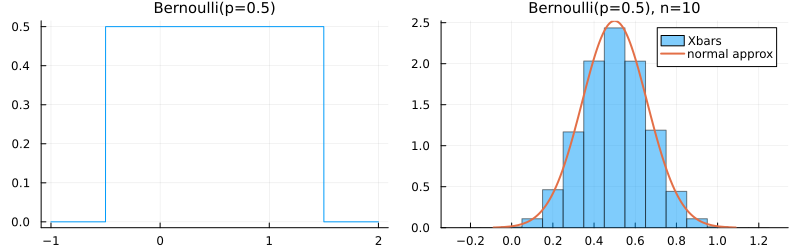

In [51]:
plot_dist_clt(Bernoulli(), 10)

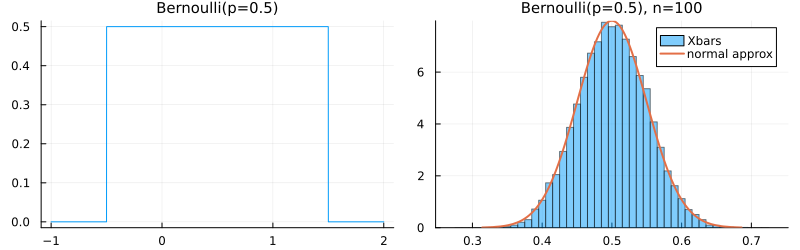

In [52]:
plot_dist_clt(Bernoulli(), 100)

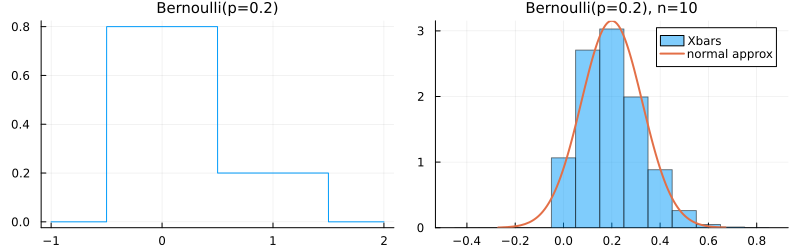

In [53]:
plot_dist_clt(Bernoulli(0.2), 10)

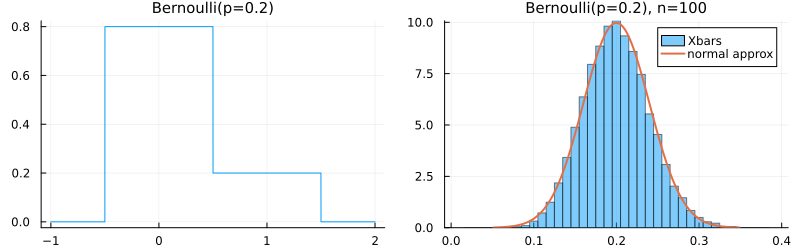

In [54]:
plot_dist_clt(Bernoulli(0.2), 100)

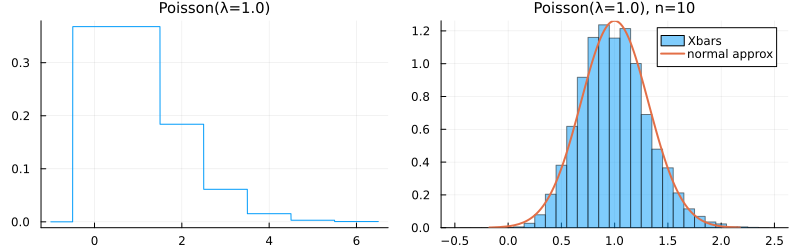

In [55]:
plot_dist_clt(Poisson(), 10)

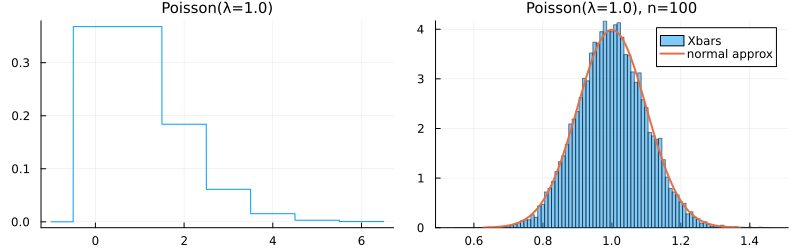

In [56]:
plot_dist_clt(Poisson(), 100)